# Study the simple setting

finetune two models and merge; can also do it in the FL setting

In [1]:
from merging import MergingFactory
from tqdm import tqdm
from copy import deepcopy
import data_utils
import torch
from train_utils import get_metric
from copy import deepcopy
from torch import nn
import matplotlib.pyplot as plt

def get_distance(model1, model2):
    distance = 0
    for n, p in model1.named_parameters():
        if p.requires_grad:
            distance += torch.sum((p - model2.state_dict()[n]) ** 2)
    return distance

/home/xingyu/anaconda3/envs/flasc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-10 14:33:28.044275: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 14:33:28.063784: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class args:
    dataset="20newsgroups"
    client_batch=16
    clients=100
    iid_alpha=0.1  # the lower, the more non-iid
    seed=0
    eval_frac=1.0
    lora_rank=16
    lora_alpha=16
    freeze_a = "false"
    merging_strategy = "average"
    return_peft_model = False  # use peft model or just add adapters; for nvative peft merging
    
# set seed for debugging
import random
import numpy as np
import torch
from transformers import set_seed
set_seed(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

## prepare models and dataloaders

In [3]:
clients, valloader, testloader, test_batch = data_utils.build_dataset(args.dataset,
                                                                      args.client_batch,
                                                                      args.clients,
                                                                      args.iid_alpha, args.seed, args.eval_frac)

import models
model = models.build_model(args.dataset)
total = sum(p.numel() for p in model.parameters() if p.requires_grad)

peft_model = models.add_adapters_dataset(args.dataset, model, args.lora_rank,
                                args.lora_alpha, ft_output_layer=True,
                                return_peft_model=args.return_peft_model)
if args.return_peft_model:
    model = peft_model
    
def str2bool(s):
    return s.lower() == 'true'

if str2bool(args.freeze_a):
    for n,p in model.named_parameters():
        if "lora_A" in n:
            p.requires_grad = False

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Training {trainable} parameters ({100*trainable/total:.2f}% of original {total})")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Found 20 classes


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training 2374656 parameters (1.91% of original 124455168)


/home/xingyu/anaconda3/envs/flasc/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


## training

In [4]:
server_freeze = False
server_lr = 1e-3 # for the original fedavg, this is one; for others like fedadam, we can set it to 1e-3

In [5]:
server_model = model
orig_server_model = deepcopy(server_model)  # backup if need

server_params = {n:p for n,p in server_model.named_parameters() if p.requires_grad}
server_mask = {n:torch.ones_like(p) for n,p in server_params.items()}
server_freeze = False
if server_freeze:
    for p in server_params.values():
        p.requires_grad = False

from train_utils import Yogi
# server_opt = torch.optim.SGD(server_params.values(), lr=server_lr)
beta1 = 0.9
beta2 = 0.999
server_opt = Yogi(server_params.values(), lr=server_lr,
                    beta1=beta1, beta2=beta2)

In [6]:
merging_strategy =  args.merging_strategy
merger = MergingFactory.get_merging_strategy(merging_strategy, server_model, args=args)
scaling_coefficient = 1.0  # no need to change

eval_accu = 0
def eval_loop(model, loader):
    model.eval()
    stats_acc = {}
    for x,y in loader:
        with torch.no_grad():
            _, stats = test_batch(model, x, y)
        for k,v in stats.items():
            stats_acc[k] = stats_acc.get(k, 0) + v
    stats_acc['loss'] /= stats_acc['count']
    return stats_acc

In [7]:
server_batch = 2  # how many clients we use
client_lr = 1e-3

# clients = [clients[0], clients[1]]  # we take out two loaders to use
client_epochs = 6  # local training epochs; in standard FL setting, this is 1
l2_clip_norm = 0.

The following cell only finetunes two models, without merging. A simple FL setup can be recovered by increasing the global rounds and adding the merging code in the training loop.

In [8]:
ft_distances = [[], []]
between_distances = []
checkpoints = [[], []]

In [16]:
merging_strategy = 'average'

rounds = 1

pbar = tqdm(range(rounds))

# select two 
client_ids = [0, 1]
client_loaders = [clients[i] for i in client_ids]

# client_loaders = clients

for round_idx, rnd in enumerate(pbar):
    # # radomly select some
    # client_ids = torch.randperm(len(clients))[:server_batch]
    # client_loaders = [clients[i] for i in client_ids]

    neg_client_deltas = []
    stats_acc = {}
    client_models = [deepcopy(server_model) for _ in range(len(client_ids))]
    # for fisher_merging, regmean_merging, the weights will be normalized
    # again in the merging function
    # for ties_merging, currently the average_weights are not passed to the merging function;
    # we can only change the scaling coefficient 
    average_weights = torch.Tensor([len(client_loader) for client_loader in client_loaders])
    if merging_strategy in ['average', 'fisher_merging', 'regmean_merging']:
        average_weights = average_weights / average_weights.sum()
    elif merging_strategy in ['ties_merging', "task_arthmetic"]:
        average_weights.fill_(1.0)  # use 1.0 for all clients, default option for now
    nums_fisher_examples = torch.Tensor([(len(client_loader)-1)*client_loader.batch_size for client_loader in client_loaders])
    nums_regmean_examples = nums_fisher_examples.clone()
    # clients_this_round = server_batch  # record the number of clients for this round


    for i, client_id in enumerate(client_ids):
        # Download Model
        client_model = client_models[i]
        client_model.to(device)

        # Local Training
        # client_opt = torch.optim.SGD(client_model.parameters(), lr=client_lr, momentum=0.9)
        client_opt = torch.optim.Adam(client_model.parameters(), lr=client_lr)
        client_loader = clients[client_id]
        client_acc = {}
        
        # use lr scheduler
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(client_opt, T_max=client_epochs)
        # scheduler = torch.optim.lr_scheduler.MultiStepLR(client_opt, milestones=[20], gamma=0.1)
        
        for epoch in range(client_epochs):
            for x,y in client_loader:
                loss, stats = test_batch(client_model, x, y)
                
                client_opt.zero_grad()
                loss.backward()

                if l2_clip_norm > 0:
                    torch.nn.utils.clip_grad_norm_(client_model.parameters(), l2_clip_norm)

                client_opt.step()
                # scheduler.step()

                for k,v in stats.items():
                    client_acc[k] = client_acc.get(k, 0) + v
                pbar.set_description(f"eval: {eval_accu} | client {i}, epoch {epoch} | loss {loss:.4f}")
                
            if epoch % 1 == 0:
                eval_model = deepcopy(client_model)
                eval_model.to(device)
                eval_results = eval_loop(eval_model, client_loader)
                print("Accuracy is {}".format(get_metric(eval_results, "accu")))
                # if epoch % 10 == 0:
                #     # test OOD accuracy
                #     # eval_results = eval_loop(eval_model, client_loaders[i^1])
                #     # print("OOD Accuracy is {}".format(get_metric(eval_results, "accu")))
                #     # save models        
                #     checkpoints[i].append(deepcopy(client_model).to("cpu"))
            
            # record distance
            ft_distances[i].append(get_distance(client_model.to("cpu"), orig_server_model).item())
            client_model.to(device)

        # This is our delta parameter
        client_model.to("cpu")  # move to cpu to save memory
        neg_client_delta = {
            n: server_params[n].data - cp.data for n,cp 
                            in client_model.named_parameters() if cp.requires_grad
        }
        neg_client_deltas.append(neg_client_delta)

        # Log last iteration
        client_acc['norm'] = 0
        for k,v in client_acc.items():
            stats_acc[k] = stats_acc.get(k, 0) + v

    # # merging
    # average_weights = torch.Tensor([len(client_loader) for client_loader in client_loaders])
    # if merging_strategy in ['average', 'fisher_merging', 'regmean_merging']:
    #     average_weights = average_weights / average_weights.sum()
    # elif merging_strategy in ['ties_merging', "task_arthmetic"]:
    #     average_weights.fill_(1.0)  # use 1.0 for all clients, default option for now

    # aggregated_update = merger.aggregate_updates(neg_client_deltas,
    #                                                 average_weights=average_weights,  # for regeman/fisher we can use, e.g., torch.tensor([4, 1])
    #                                                 scaling_coefficient=scaling_coefficient,
    #                                                 client_loaders=client_loaders,
    #                                                 test_batch=test_batch,
    #                                                 nums_fisher_examples=nums_fisher_examples,
    #                                                 nums_regmean_examples=nums_regmean_examples,
    #                                                 device=device,
    #                                                 normalize_fisher_weight=True,
    #                                                 minimal_fisher_weight = 1e-6)
    # merger.update_server_model(aggregated_update, server_opt)
    # # evaluation
    # eval_model = deepcopy(server_model)
    # eval_model.to(device)

    # print(f"Evaluation for Round {round_idx}")
    # for client_loader in client_loaders:
    #     eval_results = eval_loop(eval_model, client_loader)
    #     print(get_metric(eval_results, "accu"))
    
    # eval_results = eval_loop(eval_model, valloader)
    # print(f"Evaluation for Round {round_idx}")
    # print(get_metric(eval_results, "accu"))

eval: 0 | client 0, epoch 0 | loss 0.0962:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy is 0.9514563106796117


eval: 0 | client 0, epoch 1 | loss 0.0831:   0%|          | 0/1 [00:01<?, ?it/s]

Accuracy is 0.9805825242718447


eval: 0 | client 0, epoch 2 | loss 0.0073:   0%|          | 0/1 [00:02<?, ?it/s]

Accuracy is 1.0


eval: 0 | client 0, epoch 3 | loss 0.0031:   0%|          | 0/1 [00:04<?, ?it/s]

Accuracy is 1.0


eval: 0 | client 0, epoch 4 | loss 0.0006:   0%|          | 0/1 [00:05<?, ?it/s]

Accuracy is 1.0


eval: 0 | client 0, epoch 5 | loss 0.0001:   0%|          | 0/1 [00:06<?, ?it/s]

Accuracy is 1.0


eval: 0 | client 1, epoch 0 | loss 0.0387:   0%|          | 0/1 [00:07<?, ?it/s]

Accuracy is 0.9518072289156626


eval: 0 | client 1, epoch 1 | loss 0.0033:   0%|          | 0/1 [00:08<?, ?it/s]

Accuracy is 1.0


eval: 0 | client 1, epoch 2 | loss 0.0046:   0%|          | 0/1 [00:09<?, ?it/s]

Accuracy is 1.0


eval: 0 | client 1, epoch 3 | loss 0.0013:   0%|          | 0/1 [00:10<?, ?it/s]

Accuracy is 1.0


eval: 0 | client 1, epoch 4 | loss 0.0001:   0%|          | 0/1 [00:10<?, ?it/s]

Accuracy is 1.0


eval: 0 | client 1, epoch 5 | loss 0.0001:   0%|          | 0/1 [00:11<?, ?it/s]

Accuracy is 1.0


eval: 0 | client 1, epoch 5 | loss 0.0001: 100%|██████████| 1/1 [00:12<00:00, 12.39s/it]


In [12]:
server_model.transformer.h[0].attn.c_attn.lora_A.default.weight

Parameter containing:
tensor([[ 0.0403,  0.0024,  0.0250,  ..., -0.0416,  0.0059, -0.0153],
        [ 0.0382, -0.0182, -0.0390,  ...,  0.0248,  0.0239, -0.0067],
        [ 0.0290,  0.0183,  0.0318,  ..., -0.0025, -0.0159,  0.0228],
        ...,
        [-0.0224, -0.0411,  0.0119,  ..., -0.0406, -0.0014, -0.0172],
        [-0.0007, -0.0424, -0.0072,  ..., -0.0106,  0.0122, -0.0162],
        [-0.0081,  0.0030,  0.0068,  ..., -0.0071,  0.0383,  0.0098]],
       requires_grad=True)

In [22]:
for client_0, client_1 in zip(checkpoints[0], checkpoints[1]):
    distance = get_distance(client_0, client_1).item()
    print(distance)

293.2576904296875
346.666015625
347.8883972167969
348.7913818359375
349.5709533691406
331.12005615234375
348.4221496582031
350.11932373046875
351.3020935058594
352.3476867675781


In [25]:
# server model
cur_server_model = deepcopy(orig_server_model)
cur_server_params = {n:p for n,p in cur_server_model.named_parameters() if p.requires_grad}
cur_server_opt = Yogi(cur_server_params.values(), lr=server_lr,
                    beta1=beta1, beta2=beta2)

ckpt_idx = 5
client_0, client_1 = checkpoints[0][ckpt_idx], checkpoints[1][ckpt_idx]

cur_neg_client_deltas = []
cur_neg_client_delta = {
    n: cur_server_params[n].data - cp.data for n,cp 
                    in client_0.named_parameters() if cp.requires_grad
}
cur_neg_client_deltas.append(cur_neg_client_delta)
cur_neg_client_delta = {
    n: cur_server_params[n].data - cp.data for n,cp 
                    in client_1.named_parameters() if cp.requires_grad
}
cur_neg_client_deltas.append(cur_neg_client_delta)

# merging
merging_strategy = "average"
average_weights = torch.Tensor([len(client_loader) for client_loader in client_loaders])
if merging_strategy in ['average', 'fisher_merging', 'regmean_merging']:
    average_weights = average_weights / average_weights.sum()
elif merging_strategy in ['ties_merging', "task_arthmetic"]:
    average_weights.fill_(1.0)  # use 1.0 for all clients, default option for now

# average_weights = torch.tensor([1, 1.2])
# average_weights = average_weights / average_weights.sum()
# average_weights = torch.tensor([8, 1])
# average_weights = average_weights ** 4

merger = MergingFactory.get_merging_strategy(merging_strategy, cur_server_model, args=args)
aggregated_update = merger.aggregate_updates(cur_neg_client_deltas,
                                                average_weights=average_weights,  # for regeman/fisher we can use, e.g., torch.tensor([4, 1])
                                                scaling_coefficient=scaling_coefficient,
                                                client_loaders=client_loaders,
                                                test_batch=test_batch,
                                                nums_fisher_examples=nums_fisher_examples,
                                                nums_regmean_examples=nums_regmean_examples,
                                                device=device,
                                                normalize_fisher_weight=True,
                                                minimal_fisher_weight = 1e-6)
merger.update_server_model(aggregated_update, cur_server_opt)
# evaluation
eval_model = deepcopy(cur_server_model)
eval_model.to(device)

eval_results = eval_loop(eval_model, client_loaders[0])
print(f"Evaluation for Round {round_idx}")
print(get_metric(eval_results, "accu"))

eval_results = eval_loop(eval_model, client_loaders[1])
print(get_metric(eval_results, "accu"))

Evaluation for Round 0
0.6990291262135923
0.060240963855421686


In [20]:
eval_model = deepcopy(server_model)
eval_model.to(device)
eval_results = eval_loop(eval_model, client_loaders[0])
print(f"Evaluation for Round {round_idx}")
print(get_metric(eval_results, "accu"))

Evaluation for Round 0
0.02912621359223301


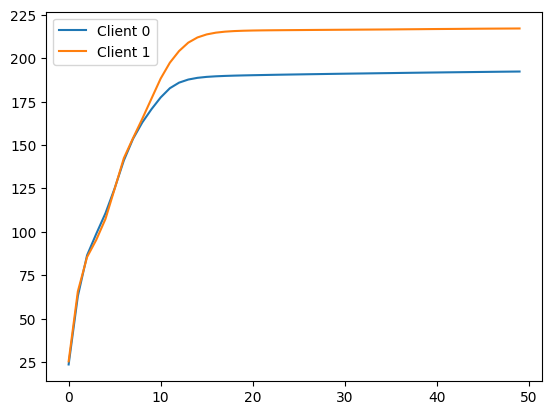

In [9]:
plt.plot(ft_distances[0], label="Client 0")
plt.plot(ft_distances[1], label="Client 1")
plt.legend()

In [11]:
print(f"Evaluation for Round {round_idx}")
for client_loader in client_loaders:
    eval_results = eval_loop(eval_model, client_loader)
    print(get_metric(eval_results, "accu"))

Evaluation for Round 9
0.9029126213592233
0.9156626506024096
0.8494623655913979
0.6486486486486487
0.8058252427184466
0.7029702970297029


In [12]:
orig_server_model = deepcopy(server_model)

In [34]:
cur_server_opt

Yogi (
Parameter Group 0
    beta1: 0.9
    beta2: 0.999
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [ ]:
cur_server_model = deepcopy(server_model)  # orig_server_model
cur_server_params = {n:p for n,p in cur_server_model.named_parameters() if p.requires_grad}
cur_server_opt = Yogi(cur_server_params.values(), lr=server_lr,
                    beta1=beta1, beta2=beta2)
# cur_server_opt_sd = cur_server_opt.state_dict()
# cur_server_opt_sd['state'] = deepcopy(server_opt.state_dict()['state'])
# cur_server_opt.load_state_dict(cur_server_opt_sd)

# merging
merging_strategy = "average"
average_weights = torch.Tensor([len(client_loader) for client_loader in client_loaders])
if merging_strategy in ['average', 'fisher_merging', 'regmean_merging']:
    average_weights = average_weights / average_weights.sum()
elif merging_strategy in ['ties_merging', "task_arthmetic"]:
    average_weights.fill_(1.0)  # use 1.0 for all clients, default option for now

# average_weights = torch.tensor([1, 1.2])
# average_weights = average_weights / average_weights.sum()
# average_weights = torch.tensor([8, 1])
# average_weights = average_weights ** 4

merger = MergingFactory.get_merging_strategy(merging_strategy, cur_server_model, args=args)
aggregated_update = merger.aggregate_updates(neg_client_deltas,
                                                average_weights=average_weights,  # for regeman/fisher we can use, e.g., torch.tensor([4, 1])
                                                scaling_coefficient=scaling_coefficient,
                                                client_loaders=client_loaders,
                                                test_batch=test_batch,
                                                nums_fisher_examples=nums_fisher_examples,
                                                nums_regmean_examples=nums_regmean_examples,
                                                device=device,
                                                normalize_fisher_weight=True,
                                                minimal_fisher_weight = 1e-6)
merger.update_server_model(aggregated_update, cur_server_opt)
# evaluation
eval_model = deepcopy(cur_server_model)
eval_model.to(device)

eval_results = eval_loop(eval_model, client_loaders[0])
print(f"Evaluation for Round {round_idx}")
print(get_metric(eval_results, "accu"))

eval_results = eval_loop(eval_model, client_loaders[1])
print(get_metric(eval_results, "accu"))

Evaluation for Round 0
0.5728155339805825
0.21686746987951808


In [14]:
eval_model = deepcopy(cur_server_model)
eval_model.to(device)

eval_results = eval_loop(eval_model, client_loaders[0])
print(f"Evaluation for Round {round_idx}")
print(get_metric(eval_results, "accu"))

Evaluation for Round 0
0.8543689320388349


In [ ]:
# calculate the distance between the client models and the server model=



dist_0 = get_distance(client_models[0], orig_server_model)
dist_1 = get_distance(client_models[1], orig_server_model)

print(f"Distance between client 0 and server model: {dist_0}")
print(f"Distance between client 1 and server model: {dist_1}")

Distance between client 0 and server model: 146.1201629638672
Distance between client 1 and server model: 161.16949462890625


In [22]:
get_distance(client_models[0], client_models[1])

tensor(349.5710, grad_fn=<AddBackward0>)

In [ ]:
# SGD
# Distance between client 0 and server model: 8.39322280883789
# Distance between client 1 and server model: 21.487966537475586

# adam
# Distance between client 0 and server model: 125.06092071533203
# Distance between client 1 and server model: 126.78553009033203

In [18]:
eval_model = deepcopy(orig_server_model)
eval_model.to(device)
eval_results = eval_loop(eval_model, client_loaders[0])
print(f"Evaluation for Round {round_idx}")
print(get_metric(eval_results, "accu"))

Evaluation for Round 0
0.02912621359223301


check the performances of the finetuned models

In [ ]:
eval_model = deepcopy(client_models[0])
eval_model.to(device)

eval_results = eval_loop(eval_model, client_loaders[0])

get_metric(eval_results, "accu")

0.43037974683544306

In [ ]:
eval_model = deepcopy(client_models[1])
eval_model.to(device)

eval_results = eval_loop(eval_model, client_loaders[1])

get_metric(eval_results, "accu")

0.45348837209302323

## merging

need to run them all everytime we try a new merging method, because we edit the `cur_server_model` in-place

In [ ]:
# copy the pretraiend model
cur_server_model = deepcopy(orig_server_model)
cur_server_params = {n:p for n,p in cur_server_model.named_parameters() if p.requires_grad}
cur_server_opt = torch.optim.SGD(cur_server_params.values(), lr=server_lr)

In [ ]:
# prepare for merging
merging_strategy = "average"
merger = MergingFactory.get_merging_strategy(merging_strategy, cur_server_model, args=args)  # average, task_arithmetic, fisher_merging, ties_merging, regmean_merging
scaling_coefficient = 1.  # controls how far we want to go in the direction of the aggregated task vector, only used in task arithmetic
param_value_mask_rate = 0.5  # controls how much parameters we want to prune/drop in ties-merging (and dare)

In [ ]:
# merging
average_weights = torch.Tensor([len(client_loader) for client_loader in client_loaders])
if merging_strategy in ['average', 'fisher_merging', 'regmean_merging']:
    average_weights = average_weights / average_weights.sum()
elif merging_strategy in ['ties_merging', "task_arthmetic"]:
    average_weights.fill_(1.0)  # use 1.0 for all clients, default option for now

aggregated_update = merger.aggregate_updates(neg_client_deltas,
                                                average_weights=average_weights,  # for regeman/fisher we can use, e.g., torch.tensor([4, 1])
                                                scaling_coefficient=scaling_coefficient,
                                                client_loaders=client_loaders,
                                                test_batch=test_batch,
                                                nums_fisher_examples=nums_fisher_examples,
                                                nums_regmean_examples=nums_regmean_examples,
                                                device=device,
                                                normalize_fisher_weight=True,
                                                minimal_fisher_weight = 1e-6,
                                                param_value_mask_rate= param_value_mask_rate)
merger.update_server_model(aggregated_update, cur_server_opt)

In [ ]:
# evaluation
eval_model = deepcopy(cur_server_model)
eval_model.to(device)

eval_results = eval_loop(eval_model, client_loaders[0])
print(get_metric(eval_results, "accu"))

eval_results = eval_loop(eval_model, client_loaders[1])
print(get_metric(eval_results, "accu"))

0.28270042194092826
0.01744186046511628


In [ ]:
# non-weighted average
# 0.620253164556962
# 0.8953488372093024

# weighted average
# 0.9282700421940928
# 0.563953488372093

# non-weighted fisher
# 0.0970464135021097
# 1.0

# non-weighted fisher
# 0.1940928270042194
# 0.9941860465116279

# weighted fisher
# 0.25316455696202533
# 0.9883720930232558

# weighted regmean
# 0.8016877637130801
# 0.9593023255813954

# non-weighted ties 
# 0.70042194092827
# 0.38953488372093026
